# Data Modelling I - Numerical

In this unit, we're going to learn about the concept of *modelling* data, in a way that allows us to make predictions beyond the data set itself.  The main focus of this unit will be *regression* models for numerical data, though we will also use spline interpolation.  We'll first have a look at an example to motivate the goals in this unit. 

In addition to our normal package import, we'll be importing a few other packages as we go.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


## Modelling Cooling

Suppose we made ourselves a cup of tea, and sat down with it and a thermometer.  Right as we sit down, we note that the temperature of the tea is 85 degrees Celsius.  Thirty seconds later, it's 80.3.  We continue measuring and find that the temperature values are 80.3, 75.4, 68.1, 64.6, 56.1, 55.6, and 51 degrees at 1,2,2.5,3.75,4, and 5 minutes respectively.  We noted that the ambient temperature of the room is 18 degrees.  Putting this all into a dataframe:

In [2]:
t = pd.DataFrame({'Temp':[85.0, 80.3, 75.4, 68.0, 64.6, 56.1, 55.6, 51.0]}, index=[0,0.5,1,2,2.5,3.75,4,5])
t

,Temp
0.00,85.0
0.50,80.3
1.00,75.4
2.00,68.0
2.50,64.6
3.75,56.1
4.00,55.6
5.00,51.0


If we were to plot this data, it would look like this:

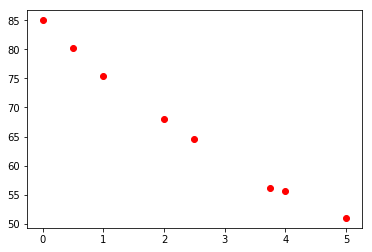

In [3]:
scatter(t.index,t['Temp'],color='red');

Now, what if we wanted to know what the temperature of the tea was going to be 10 minutes from when we started, without measuring it?  Or what if we wanted to know what the temperature was at 1.5 minutes from when we started, between two data points?  Our best bet would be to take the data we have, and fit a *mathematical model* to it, i.e.: create a function of time which outputs the temperature, and closely fits the data we have.  This way, we could input any time we wanted and have the model tell us what the temperature will be (within some level of error).  And, if our function is 'nice' enough, we could potentially take a given temperature and solve for what time that temperature occurs.

In essence, we'll have a way to represent the underlying phenomena we were measuring with our data, and will be able to gain insight beyond the scope of the individual data points we collected.

Choosing a modelling technique depends on a number of things, including the type and shape of the data, complexity of the model, etc.  We'll be looking at a number of common modelling techniques shortly. Luckily for us, there is already a model that describes the cooling of objects (and is likely familiar to anyone who has taken first year calculus).  **Newton's Law of Cooling** states that the temperature $T$ at any time $t$ for an object of inital temperature $T_0$, sitting in an room of ambient temperature $\tau$ is given by:

$$ T(t) = \tau + (T_0-\tau)e^{-kt}. $$

Here $k$ is a constant that depends on the particular objects involved, and has units of (time)$^{-1}$.  To solve for $k$, we would need two data points:  $T_0$, and the temperature $T_i$ at some other time $t_i$.  For our particular example, the value of $k\cong -\frac{1}{2}\log(\frac{50}{67})$, and so the equation becomes:

$$ T(t) = 18 + (85 - 18)e^{\frac{t}{2}\log(\frac{50}{67})} = 18 + 67\sqrt{\left(\frac{50}{67}\right)^t} $$

We can define a Python function for the model:

In [4]:
def cooling1(t):
    return 18+67*((50/67)**(t/2))

We've represented the change in temperatures as a fairly simple function, which allows us to -- given some initial conditions -- input whatever time we'd like to determine the temperature.  If we plot the function (with our particular value of $k$) against the data above, we have:

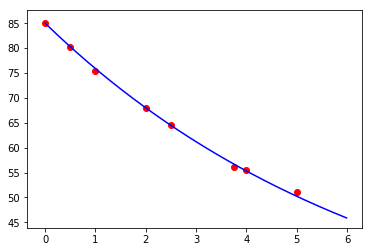

In [5]:
x = np.arange(0,6,0.01)
plt.plot(x, cooling1(x),color='blue');
scatter(t.index,t['Temp'],color='red');

As we can see, the model fits the data very well!  (There are various methods for *validating* a model on a data set, which we will see in a later unit.)

If we wanted to find out what the temperature was at 1.5 minutes (between two observations), we could compute:

In [6]:
cooling1(1.5)

71.795531651779

If we wanted to make the model a little more in line with the measurements we took, we could round to one decimal place:

In [7]:
round(cooling1(1.5),1)

71.8

And if we wanted to know what the temperature would be 10 minutes after we sat down:

In [8]:
round(cooling1(10),1)

33.5

What would the temperature be after an hour?

In [9]:
round(cooling1(60),1)

18.0

So by that point, the tea has cooled to the point where it is room temperature.

## Linear Regression

One of the simplest, and also most commonly used methods for modelling a data set is *linear regression*.  This method presumes that the relationship of the dependent variables of your data set to the independent variables is linear.  In the two-dimensional case, where the dependent variable $y$ and the independent variable $x$ are scalars, a linear relation between the two would have the form:

$$y = \beta_0 +\beta_1x + \epsilon.$$
            
Here, the $\beta_i$ are unknown coefficients that we must solve for, often called *regression coefficients*.  The $\epsilon$ is an error term that attempts to account for other factors that influence the value of $y$ beyond the independent variables $x$ (often called the *regressors*).  Here is a visual example of a two-dimensional linear regression model:



 <img src="http://i.imgur.com/FFkyPbW.png",width=700,height=700>

More generally, linear regression finds a linear relation between the dependent variables $\{y_i\}$ and the independent variables $\bf{x}_1,\ldots,\bf{x}_n$ (where each of these is a vector) with component equations:

$$ y_i = \beta_0 + \beta_1x_{i1} + \beta_2x_{i2} + \ldots + \epsilon_i $$

Rewriting this in vector form:

$$ \begin{bmatrix}y_1\\y_2\\ \vdots \\ y_n \end{bmatrix} \quad=\quad 
\begin{bmatrix}1 & x_{11} & x_{12} & \ldots & x_{1p} \\ 
1 & x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_{n1} & x_{n2} & \ldots & x_{np}\end{bmatrix}
\begin{bmatrix}\beta_1\\\beta_2\\ \vdots \\ \beta_n \end{bmatrix} \quad+\quad \begin{bmatrix}\epsilon_1\\\epsilon_2\\ \vdots \\ \epsilon_n \end{bmatrix}$$

Condensing this, using boldface to denote a vector:
$$  \bf{y} = \bf{X}\bf{\beta} + \bf{\epsilon}, $$
where $\bf{X} = \begin{bmatrix}\bf{x}_1 & \bf{x}_2 & \ldots & \bf{x}_n\end{bmatrix}^T $.

### Least Squares

How do we determine the coefficients $\beta_i$?  One of the most commonly used methods is *Ordinary Least Squares* (OLS), owing to its simplicity.  If we rewrite the vector equation above, we have $\bf{\epsilon} = \bf{X}\bf{\beta} - \bf{y}$; OLS solves for $\beta$ by find the values that minimize the "size", or magnitude, of $\epsilon$.  The square of the magnitude of a vector $\bf{v}$ is given by
$$ \big|\big|\,v\,\big|\big|^2\; = \; v^Tv \;=\; \begin{bmatrix}v_1 & v_2 & \ldots & v_n\end{bmatrix}
\begin{bmatrix}v_1 \\ v_2 \\ \vdots \\ v_n\end{bmatrix}\; =\; v_1^2 + v_2^2 + \ldots + v_n^2$$

So the OLS method finds the solutions in $\beta$ that minimizes
$$ \big|\big|\,\epsilon\,\big|\big|^2 = (\bf{X}\bf{\beta} - \bf{y})^T(\bf{X}\bf{\beta} - \bf{y})$$

As long as there is no perfect correlation (1 or -1) between any two of the $\bf{x}_i$, then there is an explicit solution that minimizes the error terms:
$$ \beta = (\bf{X}^T\bf{X})^{-1}\bf{X}^T\bf{y}$$
The details of this equation are not incredibly important at this stage (see the Appendix for more information), but its existence provides us with a simple and powerful way to compute linear regression models for most systems.  Many of the linear regression modelling tools that are included in programming packages will use this method by default.

We'll look at two linear regression tools that come with Anaconda:  one from SciPy, and one from NumPy.  

### Choosing Linear Regression

Before we look at different implementations of linear regression, one question we should ask is "when should we choose linear regression as our model?".  The short answer is "when there is a strong linear relation in our data", and there are two ways that can help us determine this.  The first is visual inspection.  As an example, let's look at two data sets:

In [10]:
# Independent Axis
x = [x for x in range(-10,10)]

# Dependent Axes
y1 = [a + round(np.random.normal(0,0.75),2) for a in x]
y2 = [a**2 + round(np.random.normal(0,3),2) for a in x]

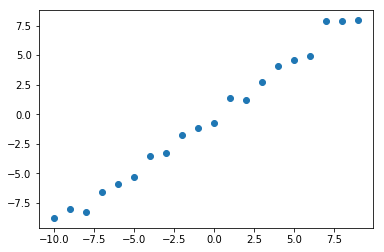

In [11]:
scatter(x,y1);

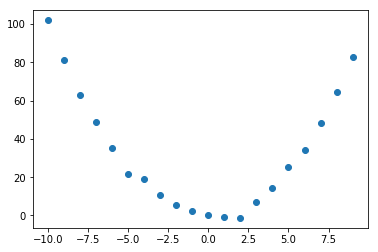

In [12]:
scatter(x,y2);

Ignoring how we made the data sets, the first plot certainly seems to be linear, but the second plot has distinct curvature that would lead us to believe that the data is not linearly related.

The second tool we have is the Pearson correlation coefficient, which we learned was a measure of how strongly two data sets are *linearly related*.  The closer to 1 or -1 the correlation is, the more strongly linearly related the data is.  We compute the correlation for each of these sets:

In [13]:
numpy.corrcoef(x,y1)

array([[1.        , 0.99508831],
       [0.99508831, 1.        ]])

In [14]:
numpy.corrcoef(x,y2)

array([[ 1.        , -0.19831905],
       [-0.19831905,  1.        ]])

The correlation for the first data set is very close to 1, reinforcing our conclusion from our visual inspection that the data is strongly linearly related.  The correlation for the second data set is much closer to 0, meaning there is no strong linear relation in the data.

### Using SciPy

The first linear regression modelling tool we will look at is from SciPy, a science/math/engineering package included with Anaconda.  We must first import the `stats` sub-package from SciPy.

In [15]:
from scipy import stats

Given an independent set $x$, and a dependent set $y$, the function `stats.linregress(x, y)` will produce the following quantities in order:  slope, intercept, r-value, p-value, stderr.  The r-value is the Pearson correlation coefficient, the stderr is the standard error of the estimated gradient, and the p-value we will learn about in a later unit.  The quantities we care about right now are the slope and the intercept, because they will allow us to define the equation of the line of our regression model.

We'll start with a data set of 20 points:

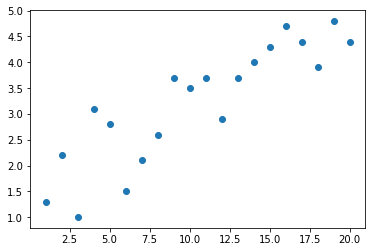

In [16]:
x = np.arange(1,21,1)
y = [1.3, 2.2, 1.0, 3.1, 2.8, 1.5, 2.1, 2.6, 3.7, 3.5, 3.7, 2.9, 3.7, 4.0, 4.3, 4.7, 4.4, 3.9, 4.8, 4.4]
scatter(x,y);

In [17]:
numpy.corrcoef(x,y)
# High correlation coefficient:

array([[1.        , 0.87678028],
       [0.87678028, 1.        ]])

In [19]:
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x, y)
# We'll only be using the first two values, but since the function outputs all 5 values, 
# we need to account for them all.

We can call the individual variables to find the values of the slope and the intercept:

In [20]:
slope

0.17007518796992485

In [21]:
intercept

1.4442105263157885

We can plot the line using the relation ` (intercept + slope * x)` as the `y`-value:

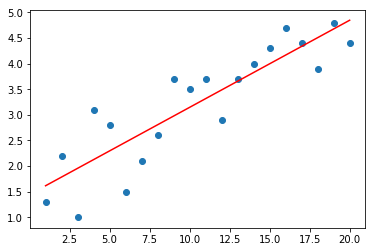

In [22]:
## can't use dates for regression. 
scatter(x,y)
plt.plot(x,intercept + slope * x, color='red');

### Using NumPy's  `polyfit()`

The `polyfit()` function from NumPy is more powerful than a simple linear regression modelling tool: it can fit the data to any polynomial we want.  We will see polynomial regression soon, but we will limit ourselves to lines in this section.  The syntax for the function is<br>
`np.polynomial.polynomial.polyfit(x, y, degree)`<br>
where `degree` is the degree of the polynomial we wish to fit.  The function outputs the coefficients in ascending order; for linear regression, `degree=1`, it will output the intercept and the slope.  Using the same data as above:

In [23]:
np_intercept, np_slope = np.polynomial.polynomial.polyfit(x, y, 1)

In [24]:
np_intercept, np_slope

(1.44421052631579, 0.17007518796992477)

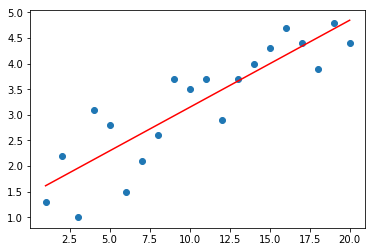

In [25]:
scatter(x,y)
plt.plot(x,np_intercept + np_slope*x, color='red');

We can verify that both methods give the same regression line:

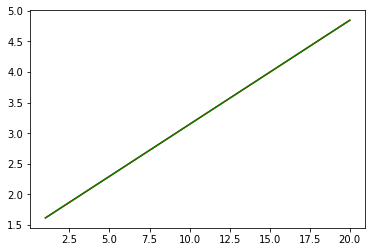

In [27]:
plt.plot(x,np_intercept + np_slope*x, color='red')
plt.plot(x,intercept + slope * x, color='green');

As an exercise, let's read in the `timeseries_1.csv` file again, and look towards modelling the volume with linear regression.

In [75]:
df = pd.read_csv('timeseries_1.csv', index_col = 0,parse_dates=True)
df.head()

,open,high,low,close,volume
2014-02-01 08:00:00,748.1,748.2,746.7,746.8,39470
2014-02-01 08:01:00,746.9,747.1,746.8,746.8,10498
2014-02-01 08:02:00,746.8,747.2,746.7,747.1,7782
2014-02-01 08:03:00,747.2,747.8,747.1,747.6,10678
2014-02-01 08:04:00,747.5,747.8,747.5,747.8,3194


In [81]:
from datetime import datetime
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

We'll create a scatter plot of the volume with the `plot_date(x,y)` function:

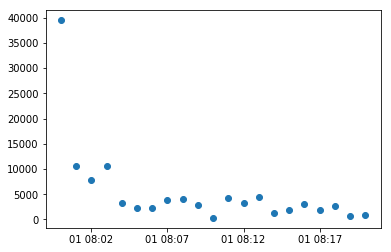

In [63]:
plt.plot_date(df.index,df['volume'])

If we try to do a linear regression on the volume, we get an error:

In [64]:
v_int, v_slope = np.polynomial.polynomial.polyfit(df.index, df['volume'], 1)

TypeError: ufunc add cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [55]:
v_int, v_slope

(12870.103896103894, -757.61038961039)

ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

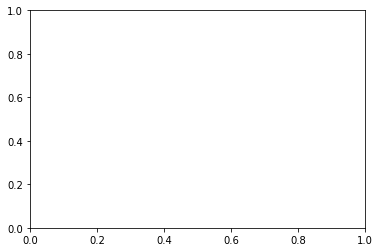

In [56]:
plt.plot(df.index,v_int + v_slope*x, color='red')

In [45]:
df2 = pd.read_csv('timeseries_1.csv',index_col=0,parse_dates=True)
df.head()

,Unnamed: 0,open,high,low,close,volume
0,02/01/2014 8:00,748.1,748.2,746.7,746.8,39470
1,02/01/2014 8:01,746.9,747.1,746.8,746.8,10498
2,02/01/2014 8:02,746.8,747.2,746.7,747.1,7782
3,02/01/2014 8:03,747.2,747.8,747.1,747.6,10678
4,02/01/2014 8:04,747.5,747.8,747.5,747.8,3194


In [ ]:
v_int, v_slope = np.polynomial.polynomial.polyfit( , df['volume'], 1)

The reason is that the regression code doesn't like datetime objects.  We know that the datetime stamps are equally spaced (one minute level); how could we adjust the dataframe so we could use the regression model?

In [34]:
v_int, v_slope

(12870.103896103894, -757.61038961039)

Once we're able to make a regression model and graph it, does it visually seem to represent the data well?  What is the correlation coefficient?

In [49]:
np.corrcoef(df.index, df['volume'])

array([[ 1.       , -0.5644404],
       [-0.5644404,  1.       ]])

### Revisiting House Prices

Back in the presentation for Unit 1, we saw a visualization of a data set containing house prices (in thousands of dollars) and area (in square feet).  Let's load in the actual data set:

In [ ]:
hp = pd.read_csv('house_prices.csv',index_col=0)
hp.head()

In [ ]:
plt.scatter(hp['Size'],hp['Price'])
plt.xlabel('House Size (Sq. Feet)')
plt.ylabel('House Price ($1000s)')
plt.grid()
plt.show()

We compute the correlation coefficient:

In [ ]:
hp.corr()

Which is very close to one.  So between the visual inspection of the scatter plot, and the correlation coefficient, we can be very confident of a linear relationship between the data.  We create a linear regression model with the `polyfit` function:

In [ ]:
hp_int, hp_slope = np.polynomial.polynomial.polyfit(hp['Size'], hp['Price'], 1)

def house_model(x):
    return x*hp_slope + hp_int

In [ ]:
plt.scatter(hp['Size'],hp['Price'], label='Price vs Size')
plt.plot(hp['Size'], house_model(hp['Size']),color='red',label='Regression Model')
plt.xlabel('House Size (Sq. Feet)')
plt.ylabel('House Price ($1000s)')
plt.legend()
plt.grid()
plt.show()

Now with this model, we can predict house prices not included:

In [ ]:
house_model(3000)

In [ ]:
house_model(4500)

# Shortcomings of Linear Regression

Linear regression is very popular because of its simplicity.  One major issue with using it, though, arises when the relationship in your data is *not* linear, such as with our cooling cup of tea.  Additionally, linear regression is very sensitive to the presence of outliers in the data.  In this case, cleaning the data, and understanding other kinds of relations present in the data are key to choosing the right modelling technique.

The statistician Francis Anscombe created a collection of four data sets -- called Anscombe's Quartet -- that have identical descriptive statistics (correlation of x and y, mean of x, mean of y, variance of x, number of data points, etc.), and identical regression lines.  The accuracy of the regression models vary wildly between sets, however.  Anscombe created this set of examples to show that visualizing and understanding data sets before modelling is very important.  Here are the four pieces of Anscombe's Quartet:

<img src="http://i.imgur.com/jvNtl1M.png",width=700,height=700>

In $y_1$, the regression line fits quite well.  In $y_2$, there definitely is a relation, but it isn't linear.  In $y_3$ there *is* a linear relation, but the presence of an outlier skews the regression model.  Lastly, there isn't any discernible relationship between the variables in $y_4$, but a fairly extreme outlier produces a large correlation coefficient, and the resulting linear regression model doesn't accurately model anything.


One shouldn't apply any kind of modelling technique blindly, but first try to gain an understanding of what the data looks like, and what assumptions exist about relationships in the data.  

## Polynomial Regression

When our data isn't related linearly, we need to find another method to create a model.  *Polynomial regression* is the natural extension of linear regression:  instead of trying to fit a line to the data set, we will try to fit a polynomial.  As a reminder, a polynomial (of one variable) is an equation of the form:
  $$ p(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n, $$
where the $a_i$ are the *coefficients*, and the number $n$ is the *degree* of the polynomial.  The method is set up in the same fashion as linear regression, following an equation of the form:

$$ y = \beta_0 + \beta_1x + \beta_2x^2 + \ldots +\beta_nx^n + \epsilon $$

The simplest forms of the first three non-linear polynomials are the quadratic $y=x^2$, the cubic $y=x^3$, and the quartic $y=x^4$:

In [ ]:
poly_x = np.arange(-3,3,0.01)
plt.plot(poly_x, poly_x**2, label='Quadratic');
plt.plot(poly_x, poly_x**3, label='Cubic');
plt.plot(poly_x, poly_x**4, label='Quartic');
plt.plot(poly_x, poly_x*0, color='black',linewidth=0.90)
plt.axvline(x=0,color='black', linewidth=0.9)
plt.grid()
plt.legend()
plt.ylim(-20,20)
plt.xlim(-3,3)

Adding nonzero coefficients to the other terms can cause the graph to change.  Here are $y=x^3$ and $y=-x^3+2x^2-5x+4$ graphed together:

In [ ]:
plt.plot(poly_x, poly_x**3);
plt.plot(poly_x, -poly_x**3 + 2*poly_x**2 - 5*poly_x+4);
plt.plot(poly_x, poly_x*0, color='black',linewidth=0.90)
plt.axvline(x=0,color='black', linewidth=0.9)
plt.grid()
plt.ylim(-20,20)
plt.xlim(-3,3)

Let us reference the `x,y` we defined earlier:<br>
`x = np.arange(1,21,1)`<br>
`y = [1.3, 2.2, 1.0, 3.1, 2.8, 1.5, 2.1, 2.6, 3.7, 3.5, 3.7, 2.9, 3.7, 4.0, 4.3, 4.7, 4.4, 3.9, 4.8, 4.4]`

We created a linear regression model for the data; let's create a quadratic regression model and see how they compare, visually.

In [ ]:
np0, np1, np2 = np.polynomial.polynomial.polyfit(x, y, 2)
scatter(x,y)
plt.plot(x,np0 + np1*x + np2*(x**2), color='red');

Plotting this model against the original:

In [ ]:
scatter(x,y);
plt.plot(x,np_intercept + np_slope*x, color='green');
plt.plot(x,np0 + np1*x + np2*(x**2), color='red');

Visual inspection suggestes that this may be following the data a little more closely than the linear model, so it may be a more accurate way to model the relationship in the data.  A more obvious example is:

In [ ]:
x_q = np.array([0,0.9,1.5,2.1,2.4,2.9,3.1,3.8,4.4,5.5])
y_q = np.array([-7.3, -2.1, -0.45, 1.39, 1.14, 1.92, 2.05, 1.26, 0.09, -4.35])
x_r = np.arange(0,6,0.01)

scatter(x_q,y_q);

In [ ]:
np.corrcoef(x_q,y_q)

In [ ]:
int_q, sl_q = np.polynomial.polynomial.polyfit(x_q, y_q, 1)
p0, p1, p2 = np.polynomial.polynomial.polyfit(x_q, y_q, 2)
scatter(x_q,y_q)
plt.plot(x_q,int_q + sl_q*x_q , color='green');
plt.plot(x_r,p0 + p1*x_r + p2*(x_r**2), color='red');

The linear regression model is clearly ill-suited for this data set, whereas the quadratic model is much more accurate.

Polynomial regression allows us to capture relationships in more complicated data sets, but the more complicated our model becomes the more likely we are to *overfit* the data.

### Overfitting

While we may be tempted to use very high-degree polynomials to model our data, one problem that arises is *overfitting*.  This means that our model overcomplicates the data and creates structure out of noise.  Overfit models will make diverging and erroneous predicts.

If we try to fit a sixth-degree polynomial to the `x,y` data we just looked at, we get:

In [ ]:
b0, b1, b2, b3, b4, b5, b6  = np.polynomial.polynomial.polyfit(x, y, 6)
x_6 = np.arange(0,20+0.01,0.01)
scatter(x,y)
plt.plot(x_6,b0 + b1*x_6 + b2*(x_6**2)+ b3*(x_6**3)+ b4*(x_6**4)+ b5*(x_6**5)+ b6*(x_6**6), color='red');

While this model is certainly more complex than a line, it's not overly clear that this is accurately represents the relationships in the data.  As a more extreme example, let's look at a data set of 10 points:

In [ ]:
x1 = np.array([0.1,2.1,2.5,3.3,6.1,7.2,8.3,8.7,9.0])
y1 = np.array([3.1,1.5,3.5,2.0,6.0,8.5,7.1,9.5,6.7])
# We turn them into arrays because NumPy doesn't like using lists of non-integers to graph things.
scatter(x1,y1);

Because this data set is small, any model we make is sensitive to small changes in data values.  Fitting a linear regression model visually seems to represent the data quite well:

In [ ]:
intc,slp = np.polynomial.polynomial.polyfit(x1, y1, 1)
d0, d1, d2, d3, d4, d5 = np.polynomial.polynomial.polyfit(x1, y1, 5)

scatter(x1,y1);
x2 = np.arange(0,10+0.01,0.01)
plt.plot(x2, intc+slp*x2,color='#F14B01');

Fitting a degree 5, and a degree 6 polynomial to the data set, however, result in strongly diverging models:

In [ ]:
scatter(x1,y1);
x2 = np.arange(0,10+0.01,0.01)
plt.plot(x2, intc+slp*x2,color='#F14B01');
plt.plot(x2,d0 + d1*x2 + d2*(x2**2)+ d3*(x2**3)+ d4*(x2**4)+ d5*(x2**5), color='green');

In [ ]:
c0, c1, c2, c3, c4, c5, c6  = np.polynomial.polynomial.polyfit(x1, y1, 6)
scatter(x1,y1);
x2 = np.arange(0,10+0.01,0.01)
plt.plot(x2, intc+slp*x2,color='#F14B01');
plt.plot(x2,c0 + c1*x2 + c2*(x2**2)+ c3*(x2**3)+ c4*(x2**4)+ c5*(x2**5)+ c6*(x2**6), color='green');

Both of these models are overly complicated for the data that's given, and produce very different results.   If the data was the temperature of an object sitting outside for given time period, then the linear model would predict the temperature at time period $t=10$ to be:

In [ ]:
intc+slp*10

But the fifth and sixth degree polynomial models would predict the temperature at $t=10$ to be:

In [ ]:
print(d0 + d1*10.0 + d2*(10.0**2)+ d3*(10.0**3)+ d4*(10.0**4)+ d5*(10.0**5))
print(c0 + c1*10.0 + c2*(10.0**2)+ c3*(10.0**3)+ c4*(10.0**4)+ c5*(10.0**5)+ c6*10.0**6)

These are very different values, and the continue to diverge pretty badly.  As $t=12$:

In [ ]:
print('linear at t=12 is', intc+slp*12)
print('quintic at t=12 is', d0 + d1*12.0 + d2*(12.0**2)+ d3*(12.0**3)+ d4*(12.0**4)+ d5*(12.0**5))
print('hexic at t=12 is',c0 + c1*12.0 + c2*(12.0**2)+ c3*(12.0**3)+ c4*(12.0**4)+ c5*(12.0**5)+ c6*12.0**6)

Would we really expect the temperature of an object sitting outside to suddenly be 120 degrees shortly after it was 9 degrees?  Or suddenly -32 degrees?  Probably not.

In [ ]:
scatter(x1,y1);
x2 = np.arange(0,11+0.01,0.01)
plt.plot(x2, intc+slp*x2,color='#F14B01');
plt.plot(x2,d0 + d1*x2 + d2*(x2**2)+ d3*(x2**3)+ d4*(x2**4)+ d5*(x2**5), color='green');
plt.plot(x2,c0 + c1*x2 + c2*(x2**2)+ c3*(x2**3)+ c4*(x2**4)+ c5*(x2**5)+ c6*(x2**6), color='purple');

Based on the data we have, the quintic and hexic models become incredibly unreasonable and their predictions are not very useful to us.

In cases like this (low count, high noise data), keeping the model as simple as possible is likely in our best interest.  The validation techniques in a later unit will help us determine how accurate our models are for our data, and thus which model we should choose.

## Multiple Linear Regression

While we discussed linear regression in full generality, all of the examples we've seen so far have only been one dimension of independents and one dimension of dependents.  i.e.: they've been of the form:
$$ y = \beta_0 + \beta_1x. $$

To give us a better sense of more complicated problems, we'll look at increasing the dimension of independents by 1; i.e.: we're going to fit a model using the equation:

$$ y = \beta_0 + \beta_1x_1 + \beta_2x_2. $$

This equation is something that we can still very easily visualize, because it described a *plane* in three-dimensional space (recall:  the standard equation of a plane in coordinates $(x,y,z)$ in $\mathbb{R}^3$ is given by $\alpha_1x+\alpha_2y+\alpha_3z +\alpha_4=0$).  

We'll load in a set of marketing & sales data, from the `MLR.csv` file.

In [ ]:
dfm = pd.read_csv('MLR.csv')
dfm.head(15)

Here, we have the Marketing Budget in hundreds of dollars, website visits measured in tens of visits, and the number of sales during the campaign (each row is a different vendor).  If we look at the correlation matrix, we can see that the data are pair-wise highly correlated, leading us to believe they is a linear relation.

In [ ]:
dfm.corr()

 We can do a scatter plot using the 3d plotting techniques we learned in the visualization unit:

In [ ]:
import mpl_toolkits.mplot3d as m3d

fig3d = m3d.Axes3D(plt.figure())
fig3d.scatter3D(dfm['Marketing Budget'],dfm['Website Visits'],dfm['Number of Sales'], color='red')
fig3d.set_xlabel('Marketing Budget ($100)')
fig3d.set_ylabel('Website Visits (10)')
fig3d.set_zlabel('Number of Sales')
plt.show()

We're going to use scikit-learn's regression tools, but will look at a different one in the exercises.  We need to import the `linear_model` sub-package from `sklearn`, and then define a variable as an instance of the `LinearRegression` tool.

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In our case, the `Marketing Budget` and `Website Visits` are our *features*, and the dependent variable is the `Number of Sales`.  To perform the regression, we feed `reg.fit()` the independents, and then the dependent.  We can obtain the coefficients and the intercept for the linear model as follows:

In [ ]:
reg.fit(dfm[['Marketing Budget','Website Visits']],dfm['Number of Sales'])
a,b = reg.coef_
c = reg.intercept_

In [ ]:
print(a,b,c)

In [ ]:
dfm['Marketing Budget'].max()

We now have the $a,b,c$ for our linear model $z=ax+by+c$, and can plot it:

In [ ]:
X = np.arange(0,dfm['Marketing Budget'].max(),0.1)
Y = np.arange(0,dfm['Website Visits'].max(),0.1)
xx, yy = np.meshgrid(X, Y);

Z = a*xx + b*yy+c

pln = m3d.Axes3D(plt.figure())
pln.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
plt.show();

Now we can plot them with each other:

In [ ]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.scatter3D(dfm['Marketing Budget'],dfm['Website Visits'],dfm['Number of Sales'],color='red')
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Marketing Budget ($100)')
fig3d.set_ylabel('Website Visits (10)')
fig3d.set_zlabel('Number of Sales')
plt.show()

In [ ]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.scatter3D(dfm['Marketing Budget'],dfm['Website Visits'],dfm['Number of Sales'],color='red')
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Marketing Budget ($100)')
fig3d.set_ylabel('Website Visits (10)')
fig3d.set_zlabel('Number of Sales')
fig3d.view_init(0, -17)
plt.show()

In [ ]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.scatter3D(dfm['Marketing Budget'],dfm['Website Visits'],dfm['Number of Sales'],color='red')
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Marketing Budget ($100)')
fig3d.set_ylabel('Website Visits (10)')
fig3d.set_zlabel('Number of Sales')
fig3d.view_init(25, 60)
plt.show()

We could now use this model to predict how many sales we would expect if we had a vendor who, say, spent $\$160$ on marketing, and had 21 website visits.

In [ ]:
def marketing_model(budget, visits):
    # We'll round to the nearest 1, since you can't really have a partial sale in this case.
    return np.round(3.63665549764*budget + 6.5617198341*visits + 0.098233780527,0)

marketing_model(1.6,2.1)

## Spline Interpolation

One numerical modelling technique that differs from regression is *spline interpolation*.  This method, being interpolative, is only useful for making a model that predicts points *between* our given data points, but not *outside* of boundaries.

The idea behind spline interpolation is to take each of your data points and connect them with polynomials, such that the polynomials "smoothly" transition into each other (in the sense of calculus, that the transition from one polynomial to another is doubly differentiable).  Most spline interpolation packages restrict to using cubics, because they are the polynomial of the minimum degree to meet the smoothness criterion; this way the model does not become overly complicated.  Here is a visual diagram:

 <img src="http://i.imgur.com/QQj8x7S.png",width=600,height=600>

One of the advantages of this kind of modelling is that it necessarily *includes all of your data points*, which the regression models do not.  We use the `interp1d` function from SciPy (for one dimensional interpolation):

In [ ]:
from scipy.interpolate import interp1d

We'll use our temperature data set to create a spline interpolation.  The syntax is `interp1d(x,y,kind='cubic')`; we set this to a variable, and then feed it a set of points to plot against as a function argument.

In [ ]:
f2 = interp1d(t.index, t['Temp'], kind='cubic')

In [ ]:
x2 = np.arange(0,5,0.01)
scatter(t.index,t['Temp'],color='red')
plt.plot(x2,f2(x2),color='green')

Comparing it against the model we know works:

In [ ]:
x2 = np.arange(0,5,0.01)
scatter(t.index,t['Temp'], color='red')
plt.plot(x2, cooling1(x2),color='blue',linestyle='--')
plt.plot(x2,f2(x2),color='green')

It follows the actual model fairly well, but some of the diversions occur because there are errors in our measurements (compare some of the points we measured against what the function says).  Choosing this interpolation method will depend on how accurate the data points we have are.

Let's compare the well-fitting quadratic regression model for `(x_q,y_q)` against a spline interpolation model:

In [ ]:
f3 = interp1d(x_q, y_q, kind='cubic')
x_r = np.arange(0,5.5+0.01,0.01)
scatter(x_q,y_q,color='red')
plt.plot(x_r,f3(x_r),color='green')

In [ ]:
x_r = np.arange(0,5.5+0.01,0.01)
scatter(x_q,y_q,color='red')
plt.plot(x_r,f3(x_r),color='green')
plt.plot(x_r,p0 + p1*x_r + p2*(x_r**2), color='blue',linestyle='--');

The spline model definitely fits better than the linear regression model did, and follows the quadratic model fairly closely (with a few diverging features).  

Let's look at a practical example.  Suppose we have the following set of prices for a financial instrument, at the 5-second level:

In [ ]:
pcs = [149.4, 149.5, 149.5, 149.7, 149.4, 149.5, 149.4, 149.6, 149.1, 149.5, 149.5, 149.3, 149.4, 149.5, 149.2, 
       149.5, 149.4, 149.5, 149.3, 149.6, 149.4]
dfp = pd.DataFrame({'Price':pcs}, index=pd.date_range('2017-01-01 09:30:00',periods=21,freq='5S'))
dfp.head()

In [ ]:
scatter(list(range(0,21)),dfp['Price'])

If we wanted to make a model to infer the prices between the 5-second timestamps, spline interpolation would be a good first choice of model, as it will make sure that the actual prices are included (since none of the regression nethods we've looked at would give us a model that would allow us to infer intra-measurement prices, and also include all of the data we have).

In [ ]:
p1 = interp1d(list(range(21)), dfp['Price'], kind='cubic')
x_p = np.arange(0,20+0.009,0.01)
scatter(list(range(0,21)),dfp['Price'])
plt.plot(x_p,p1(x_p),color='green');

We could now use the model to predict what the price was at 9:30:02, and at 9:31:28

In [ ]:
p1(0.4) # why 0.4?

In [ ]:
p1(17.6) # why 17.6?

In [ ]:
x_p = np.arange(0,20+0.009,0.01)
scatter(list(range(0,21)),dfp['Price'])
scatter(0.4,p1(0.4),color='red',marker='D')
scatter(17.6,p1(17.6),color='red',marker='D')
plt.plot(x_p,p1(x_p),color='green');

**Note**:  It's likely that these *weren't* the actual prices inbetween the given timestamps, but that's what the model is for:  if we didn't have access to the actual prices, a model will give us a way to infer what the prices probably were, based on the data we have at hand.  We choose a modelling mathod (and validation techniques, which we will see soon) which give us confidence in the predictions that have been made.

Ultimately, spline interpolation is a good way to create a mathematically well-behaved model when you need to make sure that all of the data points are included in the model. 

### When not to use splines

Recall the house prices vs size data we saw earlier:

In [ ]:
plt.scatter(hp['Size'],hp['Price'], label='Price vs Size')
plt.xlabel('House Size (Sq. Feet)')
plt.ylabel('House Price ($1000s)')
plt.legend()
plt.grid()
plt.show()

In this data set, we don't have a continuous relation, but rather, a number of "noisy" data points which represent an underlying structure (the linear regression model we made); as a result, the individual data points do not need to be included in the model.  If we attempted to make a spline model for this:

In [ ]:
house_spline = interp1d(hp['Size'], hp['Price'], kind='cubic')
x_h = np.arange(hp['Size'][0],hp['Size'][len(hp)-1]+1,1)

plt.scatter(hp['Size'],hp['Price'], label='Price vs Size')
plt.plot(x_h,house_spline(x_h),color='green',label='Spline')
plt.plot(hp['Size'], house_model(hp['Size']),color='red',label='Regression Model')
plt.xlabel('House Size (Sq. Feet)')
plt.ylabel('House Price ($1000s)')
plt.legend()
plt.grid()
plt.show()

We can see that the spline model is a very poor representation of the data, and massively overfits in many places.  Since the house prices have a very high correlation coefficient, and a visual inspection shows a "noisy" linear relationship, our best bet is to stick to the linear regression model.

# Assignment 7

1. Take the data we had for the tea cooling, and fit a linear regression model to it.  Use the `cooling1(t)` function to expand the data set to include the value for `t=6`.  Make a linear regression model for this new data set.  By adding a single data point, by how much did the slope of the regression model increase or decrease (as a percentage of the original slope)?
2. Using the marketing data `MLR.csv` from the multiple linear regression section, create individual single linear regression models for budget vs sales, and visits vs sales.  By what percentage were each of these models off from the value we got for `marketing_model(1.6,2.1)`?
3. Consider the data set from the overfitting section: <br>
`x1 = np.array([0.1,2.1,2.5,3.3,6.1,7.2,8.3,8.7,9.0])
y1 = np.array([3.1,1.5,3.5,2.0,6.0,8.5,7.1,9.5,6.7])`<br>
 Create a cubic (degree 3 polynomial) regression model for it.  Suppose that it turned out there was an 11th data point we
 didn't know about before: `(x,y)=(10,8.9)`.  Which of the models (linear, cubic, and degree 5 polynomial) most accurately predicted this data point? (i.e.: for which model was the distance minimized between the model's prediction for `x=10` and the actual data point?)
4. Use the `customer_info.csv` for these questions.  Instead of using sklearn's multiple linear regression, instead use statsmodel's OLS regression from `statsmodels.formula.api`.  Documentation can be found here:<br>
http://www.statsmodels.org/dev/example_formulas.html<br>

  1.  The big Telecom that you work for is interested in the relationship between the number of employees who work at a company, and how much they spend on different products. Perform two linear regressions, each with EMP as the independent variable, but with MOBILITY as the dependent variable in one and INTERNET as the dependent variable in the other. Describe in words the relationship between each of these revenue categories and the number of employees at a company. Do these results make sense to you? Why or why not?
  2.   We are now interested in how the relationship between Mobility revenue and employees changes across different industries. Pick two industries to investigate, and create two data frames, each with data on one of your chosen industries. Run a regression on each data frame to see how the relationship between the number of employees changes between industries. Describe your findings in words. (Note: it would be good if we could organize ourselves so that at least one person is doing each possible pair of industries.)
  3. Repeat the same exercise with Internet revenue instead of Mobility.
  4. (Optional) To see how effects differ across categorical variables using a regression, it is useful to use an interaction term. Use an interaction term to investigate the effect of employees on mobility across all industries.
  5.  Use your findings to make a recommendation to the marketing team about how they could use information about how many employees work at companies to create campaigns with the highest return.

5. (Bonus) Using the cooling model we made for the cup of tea, find the precise time (minutes, to within 2 decimal places) that the tea reaches room temperature. 

# Appendix

We learned that we can multiply two matrices, $A$ and $B$, to get a new matrix $AB$ if the number of *columns* of $A$ equals the number of *rows* of $B$; i.e.: if $A$ is $m\times n$ and $B$ is $j\times k$, then we can multiply $AB$ if and only if $n=j$.  For example, if $A$ is $3\times 2$, and $B$ is $2\times 5$, then we can multiply $AB$; the result will be a $3\times 5$ matrix.

If the matrices involved are *square* (the number of rows and columns are the same) of the same size, then we can always multiply them.  There is a special matrix, called the *identity matrix*, which consists of $1$s on the main diagonal, and $0$s everywhere else.  The $3\times 3$ identity matrix looks like this:

$$ I = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1  \end{bmatrix} $$

What's special about the identity matrix is that if you multiply it with any other matrix $A$ (of the same size), then the result is $A$.  The analogy is that when you multiply any number $x$ by $1$, it doesn't change $x$.

Certain square matrices have the special property that they are *invertible*:  a square matrix $A$ is invertible if there exists another matrix $B$ such that $AB = BA = I$.  If such a $B$ exists, we label it $A^{-1}$, the *inverse* of $A$.  Figuring out whether a matrix is invertible involves computing the determinant, and finding the inverse involves a series of linear equations (which is what computers are good at).  So in the equation we saw above

$$ \beta = (\bf{X}^T\bf{X})^{-1}\bf{X}^T\bf{y}$$

the matrix $(\bf{X}^T\bf{X})$ is invertible specifically because of the condition "no perfect correlation (1 or -1) between any two of the $\bf{x}_i$".